In [180]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

# MIDS - w261 Machine Learning At Scale


## Project 4


---
__Name:__  Hyera Moon     
__Week:__   4
 

# Table of Contents <a name="TOC"></a> 

1.  [HW Intructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW  Problems](#3)   
    1.0.  [HW4.0](#1.0)   
    1.0.  [HW4.1](#1.1)   
    1.2.  [HW4.2](#1.2)   
    1.3.  [HW4.3](#1.3)    
    1.4.  [HW4.4](#1.4)    
    1.5.  [HW4.5](#1.5)    
    1.6.  [HW4.6](#1.6)    
    1.7.  [HW4.7](#1.7)    
   

<a name="1"></a>
# 1 Instructions
[Back to Table of Contents](#TOC)



<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* See async lecture and live lecture

<a name="3">
# HW Problems
[Back to Table of Contents](#TOC)

## HW4.0  <a name="1.0"></a>
[Back to Table of Contents](#TOC)

What is MrJob? How is it different to Hadoop MapReduce? 
What are the mapper_init, mapper_final(), combiner_final(), reducer_final() methods? When are they called?

MrJob is a Python package that helps to write and run Hadoop streaming jobs. It differs from the Hadoop MapReduce in several ways:
- Multisteps: not all computations can be done in one step in Hadoop MapReduce but MrJob can produce multisteps job  
- MrJob can be tested on local machine but also can be run in Hadoop mode. In local mode, can be run very fast at "Python speed"
- MrJob keeps all MapReduce code for one job in a single class
- With MrJob, it is easy to switch input and output formats (single line of code needed)
- MrJob is very simple and easy to install

The methods in the question above:  
- **mapper_init()**: mapper_init() method is called at the beginning of the mapper task. It is to define an action to run before the mapper processes any input. It is frequently used to initialize mapper-specific helper structures.  
- **mapper_final()**: mapper_final() method is called at end of the mapper task and emits the outputs of the mapper task.  It is used to define an action to run after the mapper reaches the end of input. Note that when using the mapper_final() method, the mapper() method does not yield any final outputs (except some internal data within the mapper phase to be used by the mapper_final) but the mapper_final() method will be emitting the final mapper task outputs. This is usually to optimize the mapper task outputs by emitting a smaller set of outputs than the mapper would have output (like an in-memory combiner). In other words, it can be used to store a total in an instance variable, and output it after reading all input data.
- **combiner_final()**: same concept as mapper_final() but for combiner task  
- **reducer_final()**: same concept as mapper_final() but for reducer task

## HW4.1  <a name="1.1"></a>
[Back to Table of Contents](#TOC)
What is serialization in the context of MrJob or Hadoop? 
When it used in these frameworks? 
What is the default serialization mode for input and outputs for MrJob? 

In [2]:
%%bash
curl -L http://archive.ics.uci.edu/ml/machine-learning-databases/anonymous/anonymous-msweb.data -o anonymous-msweb.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1389k  100 1389k    0     0   881k      0  0:00:01  0:00:01 --:--:--  882k


##### Serialization:

1) What is serialization in the context of MrJob or Hadoop?  
Serialization is the process of turning structured objects into a byte stream that can be transmitted, stored and reconstructed later in a different computer environment, if needed. Deserialization is the reverse process of serialization. In the context of MrJob of Hadoop, data needs to be serialized/deserialized (i.e. switch input/output formats) in a specific format to be readable for different job steps (mappers, reducers) and to be transmitted from one step to another. For example, MRJob accepts as input text formats raw text and JSON and thus, binary formats first need to be translated into MrJob accepted format.  


2) When is it used in these frameworks?  
Serialization and deserialization is used at each job step (in case of binary format file, deserialize file as input data before mapper is run, convert into JSON format when and when data is transmitted from one step to another (e.g. mapper to reducer). Also, given that MRJob is an abstraction layer above Hadoop, data structures have to be serialized to text for Hadoop streaming to process and transfer data (e.g. total sorting, data structure will be sorted as strings - a "serialized" format).  


3) What is the default serialization mode for input and outputs for MrJob?  
MrJob uses protocols to translate raw bytes into key, value pairs. The default serialization mode (protocols) for MrJob are:
   - as input protocol: RawValueProtocol (output value as a string and discard key - more specifically, key is read in as None).
   - as internal and output protocols: JSONProtocol (encode key, value as two JSONs separated by a tab)

## HW4.2  <a name="1.2"></a> Preprocess log file data
[Back to Table of Contents](#TOC)

Recall the Microsoft logfiles data from the async lecture. The logfiles are described are located at:

https://kdd.ics.uci.edu/databases/msweb/msweb.html
http://archive.ics.uci.edu/ml/machine-learning-databases/anonymous/

This dataset captures which areas (Vroots) of www.microsoft.com each user visited in a one-week timeframe in Feburary 1998.


#### Data Format
<PRE>
The data is in an ASCII-based sparse-data format called "DST". Each line of the data file starts with a letter which tells the line's type. The three line types of interest are:
-- Attribute lines:
For example, 'A,1277,1,"NetShow for PowerPoint","/stream"'
Where:
  'A' marks this as an attribute line, 
  '1277' is the attribute ID number for an area of the website (called a Vroot),
  '1' may be ignored, 
  '"NetShow for PowerPoint"' is the title of the Vroot, 
  '"/stream"' is the URL relative to "http://www.microsoft.com"

Case and Vote Lines:
For each user, there is a case line followed by zero or more vote lines.
For example:
  C,"10164",10164
  V,1123,1
  V,1009,1
  V,1052,1
Where:
  'C' marks this as a case line, 
  '10164' is the case ID number of a user, 
  'V' marks the vote lines for this case, 
  '1123', 1009', 1052' are the attributes ID's of Vroots that a user visited. 
  '1' may be ignored.
</PRE>
---
 Here, you must transform/preprocess the data on a single node (i.e., not on a cluster of nodes) from the following format:

- C,"10001",10001   #Visitor id 10001
- V,1000,1          #Visit by Visitor 10001 to page id 1000
- V,1001,1          #Visit by Visitor 10001 to page id 1001
- V,1002,1          #Visit by Visitor 10001 to page id 1002
- C,"10002",10002   #Visitor id 10001
- V
- Note: #denotes comments


to the following format (V, PageID, 1, C, Visitor):

- V,1000,1,C, 10001
- V,1001,1,C, 10001
- V,1002,1,C, 10001

Write the python code to accomplish this transformation.

In [3]:
#START STUDENT CODE42

with open('anonymous-msweb.data', "r") as mswebfile, open('anonymous-msweb-preprocessed.data', "a") as outputfile:
    #for line in mswebfile.readlines():
    for line in mswebfile:
        line = line.strip()
        line = line.split(",")
    
        if line[0].upper() == "C":
            caseline = line
            outputfile.write(','.join(map(str,line)) +'\n')  # Keep the same case line
        
        elif line[0].upper() == "V":
            outputfile.write(','.join(map(str,line)) + ',' + caseline[0] + ',' + caseline[1] +'\n')  # Append case line info to vroot line
        
        elif line[0].upper() == "A":
            outputfile.write(','.join(map(str,line)) +'\n')  # Keep the same attribute line


#END STUDENT CODE42

In [4]:
!head -10 anonymous-msweb-preprocessed.data
!wc -l anonymous-msweb-preprocessed.data

A,1287,1,"International AutoRoute","/autoroute"
A,1288,1,"library","/library"
A,1289,1,"Master Chef Product Information","/masterchef"
A,1297,1,"Central America","/centroam"
A,1215,1,"For Developers Only Info","/developer"
A,1279,1,"Multimedia Golf","/msgolf"
A,1239,1,"Microsoft Consulting","/msconsult"
A,1282,1,"home","/home"
A,1251,1,"Reference Support","/referencesupport"
A,1121,1,"Microsoft Magazine","/magazine"
  131659 anonymous-msweb-preprocessed.data


## HW4.3  <a name="1.3"></a> Find the most frequent pages

[Back to Table of Contents](#TOC)

Find the 5 most frequently visited pages using MrJob from the output of 4.2 (i.e., transfromed log file).

In [100]:
%%writefile MostFrequentVisits.py
#!/usr/bin/env python
#START STUDENT CODE43

from mrjob.job import MRJob
from mrjob.job import MRStep


class MostFrequentVisits(MRJob):
    # Note: To not be run on fake-it mode but to be run in Hadoop mode
    
    MRJob.SORT_VALUES = True        
    
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k2,2nr -k1,1',
            'mapred.reduce.tasks': 1
        }
        return [
            MRStep(mapper_init=self.init_get_pages,
                      mapper = self.get_pages,
                      mapper_final = self.final_get_pages,
                      reducer =self.count_pages),
            MRStep(jobconf = JOBCONF_STEP,
                   reducer = self.reducer_find_frequent
                  )
        ]
    
    def init_get_pages(self):
        self.pages = {}
        
    def get_pages(self, _, line):
        # using in memory combiner
        attribute, page, other = line.strip().split(',',2)
        page = str(page)
        if attribute == "V":
            self.pages.setdefault(page, 0)
            self.pages[page] = self.pages[page] + 1
                
    def final_get_pages(self):
        for page, visit_counts in self.pages.iteritems():
            yield page, visit_counts
            
    def count_pages(self, page, visit_counts):
        yield page, sum(visit_counts)
        
    def reducer_find_frequent(self, page, visit_counts):
        yield page, sum(visit_counts)
    
        

if __name__ == '__main__':
    MostFrequentVisits.run()
    

#END STUDENT CODE43

Overwriting MostFrequentVisits.py


In [101]:
!chmod +x MostFrequentVisits.py

In [102]:
!python MostFrequentVisits.py -r hadoop anonymous-msweb-preprocessed.data > 43_outputs.txt

No configs found; falling back on auto-configuration
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Creating temp directory /tmp/MostFrequentVisits.root.20170204.051357.678976
Copying local files to hdfs:///user/root/tmp/mrjob/MostFrequentVisits.root.20170204.051357.678976/files/...
Detected hadoop configuration property names that do not match hadoop version 2.6.0:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 2...
  mapred.text.key.partitioner.options is deprecated. Instead, use mapreduce.part

In [103]:
print "The 5 most frequently visited pages are (page and count):"
!head -5 43_outputs.txt

The 5 most frequently visited pages are (page and count):
"1008"	10836
"1034"	9383
"1004"	8463
"1018"	5330
"1017"	5108


## HW4.4  <a name="1.4"></a> Find the most frequent visitor

[Back to Table of Contents](#TOC)

Find the most frequent visitor of each page using MrJob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.  You may get a weird result.  HINT: The maximum visits by any visitor to any given webpage is 1.

In [2]:
from IPython.display import Image, HTML

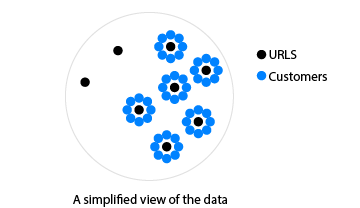

In [3]:
Image('ms-data.png')

In [141]:
# To create a file with only URL attributes
with open('anonymous-msweb.data', "r") as mswebfile, open('anonymous-msweb-URL.data', "a") as outputfile:
    #for line in mswebfile.readlines():
    for line in mswebfile:
        line = line.strip()
        line = line.split(",")
    
        if line[0].upper() == "A":
            outputfile.write(','.join(map(str,line)) +'\n')  # Keep the same attribute line


In [246]:
%%writefile mostFrequentVisitors.py
#!/usr/bin/env python
#START STUDENT CODE44

from mrjob.job import MRJob
from mrjob.job import MRStep

class mostFrequentVisitors(MRJob):
    
    MRJob.SORT_VALUES = True
    

    
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1,1 -k2,2nr',
            'mapred.reduce.tasks': 1
        }
        return [
            MRStep(
                mapper_init = self.init_get_pages_per_visitor,
                mapper = self.get_pages_per_visitor,
                mapper_final = self.final_get_pages_per_visitor,
                reducer = self.count_pages_per_visitor
                )
            ,
            MRStep(
                jobconf=JOBCONF_STEP,
                reducer_init = self.init_previous_page,
                reducer = self.reducer_find_frequent_visitor
            )
        ]
    
    def init_get_pages_per_visitor(self):
        self.pages = {}
        self.URLs ={}  # dictionary with key = pageID and value = URLs
        with open("anonymous-msweb-URL.data", "r") as url_file:
            for line in url_file:
                line = line.strip()
                data = line.split(',')
                url_ID = str(data[1])
                self.URLs[url_ID] = data[4].strip("\"")
        
    def get_pages_per_visitor(self, _, line):
        # using in memory combiner
        attribute, pageID, other = line.strip().split(',',2)
        pageID = str(pageID)
        
        if attribute == "V":
            one, customer, customerID = other.split(',',2)
            customerID = str(customerID.strip("\""))
            key = pageID + "___" + self.URLs[pageID] + "___" + customerID
            self.pages.setdefault(key, 0)
            self.pages[key] = self.pages[key] + 1
        self.pages["9999___sampleURL___99999"] = 0
                
    def final_get_pages_per_visitor(self):
        for key, visit_counts_per_customer in self.pages.iteritems():
            yield key, visit_counts_per_customer
            
    def count_pages_per_visitor(self, key, visit_counts_per_customer):
        yield key, sum(visit_counts_per_customer)
    
    def init_previous_page(self):
        self.current_page = None
        self.current_countmax = 0
        self.current_URL = None
        self.current_customerID = None
    
    def reducer_find_frequent_visitor(self, key, visit_counts_per_customer):
        page_ID, URL, customerID = key.split("___")
        count = sum(visit_counts_per_customer)
        
        if self.current_page == page_ID:
            if count > self.current_countmax:
                self.current_page = page_ID
                self.current_countmax = count
                self.current_URL = URL
                self.current_customerID = customerID
        else:
            if self.current_page:
                yield self.current_page, (self.current_countmax, self.current_URL, self.current_customerID)
               
            self.current_page = page_ID
            self.current_countmax = count
            self.current_URL = URL
            self.current_customerID = customerID
        

if __name__ == '__main__':
    mostFrequentVisitors.run()
    

#END STUDENT CODE44

Overwriting mostFrequentVisitors.py


In [184]:
!chmod a+x mostFrequentVisitors.py

In [251]:
%reload_ext autoreload
%autoreload 2

from mostFrequentVisitors import mostFrequentVisitors
mr_job = mostFrequentVisitors(args=['-r','hadoop', 'anonymous-msweb-preprocessed.data', \
                                    '--file=anonymous-msweb-URL.data'])

with mr_job.make_runner() as runner, open('44_outputs.txt',"w+") as outputfile: 
    runner.run()
    # stream_output: get access of the output
    
    for line in runner.stream_output():
        page_id, info = mr_job.parse_output_line(line)
        URL = info[1]
        customer_id = info[2]
        outputfile.write('%s\t%s\t%s\n' %(page_id, URL, customer_id))
        
# Results are saved in the file 44_outputs.txt

## HW4.5  <a name="1.5"></a> Clustering Tweet Dataset

[Back to Table of Contents](#TOC)

Here you will use a different dataset consisting of word-frequency distributions 
for 1,000 Twitter users. These Twitter users use language in very different ways,
and were classified by hand according to the criteria:

0: Human, where only basic human-human communication is observed.

1: Cyborg, where language is primarily borrowed from other sources
(e.g., jobs listings, classifieds postings, advertisements, etc...).

2: Robot, where language is formulaically derived from unrelated sources
(e.g., weather/seismology, police/fire event logs, etc...).

3: Spammer, where language is replicated to high multiplicity
(e.g., celebrity obsessions, personal promotion, etc... )

Check out the preprints of  recent research,
which spawned this dataset:

* http://arxiv.org/abs/1505.04342
* http://arxiv.org/abs/1508.01843

The main data lie in the accompanying file:

* [topUsers_Apr-Jul_2014_1000-words.txt](https://www.dropbox.com/s/6129k2urvbvobkr/topUsers_Apr-Jul_2014_1000-words.txt?dl=0)

and are of the form:

USERID,CODE,TOTAL,WORD1_COUNT,WORD2_COUNT,...
.
.

where

USERID = unique user identifier
CODE = 0/1/2/3 class code
TOTAL = sum of the word counts

Using this data, you will implement a 1000-dimensional K-means algorithm in MrJob on the users
by their 1000-dimensional word stripes/vectors using several 
centroid initializations and values of K.

Note that each "point" is a user as represented by 1000 words, and that
word-frequency distributions are generally heavy-tailed power-laws
(often called Zipf distributions), and are very rare in the larger class
of discrete, random distributions. For each user you will have to normalize
by its "TOTAL" column. __Try several parameterizations and initializations__ :

* (A) K=4 uniform random centroid-distributions over the 1000 words (generate 1000 random numbers and normalize the vectors)
* (B) K=2 perturbation-centroids, randomly perturbed from the aggregated (user-wide) distribution 
* (C) K=4 perturbation-centroids, randomly perturbed from the aggregated (user-wide) distribution 
* (D) K=4 "trained" centroids, determined by the sums across the classes. Use use the 
(row-normalized) class-level aggregates as 'trained' starting centroids (i.e., the training is already done for you!).
Note that you do not have to compute the aggregated distribution or the 
class-aggregated distributions, which are rows in the auxiliary file:


* [topUsers_Apr-Jul_2014_1000-words_summaries.txt](https://www.dropbox.com/s/w4oklbsoqefou3b/topUsers_Apr-Jul_2014_1000-words_summaries.txt?dl=0)

Row 1: Words
Row 2: Aggregated distribution across all classes
Row 3-6 class-aggregated distributions for clases 0-3
For (A),  we select 4 users randomly from a uniform distribution [1,...,1,000]
For (B), (C), and (D)  you will have to use data from the auxiliary file: 

* [topUsers_Apr-Jul_2014_1000-words_summaries.txt](https://www.dropbox.com/s/w4oklbsoqefou3b/topUsers_Apr-Jul_2014_1000-words_summaries.txt?dl=0)

This file contains 5 special word-frequency distributions:

* (1) The 1000-user-wide aggregate, which you will perturb for initializations
in parts (B) and (C), and
* (2-5) The 4 class-level aggregates for each of the user-type classes (0/1/2/3)


In parts (B) and (C), you will have to perturb the 1000-user aggregate 
(after initially normalizing by its sum, which is also provided).
So if in (B) you want to create 2 perturbations of the aggregate, start
with (1), normalize, and generate 1000 random numbers uniformly 
from the unit interval (0,1) twice (for two centroids), using:

In [ ]:
from numpy import random
numbers = random.sample(1000)

Take these 1000 numbers and add them (component-wise) to the 1000-user aggregate,
and then renormalize to obtain one of your aggregate-perturbed initial centroids.

In [ ]:
###################################################################################
##Geneate random initial centroids around the global aggregate
##Part (B) and (C) of this question
###################################################################################
def startCentroidsBC(k):
    counter = 0
    for line in open("topUsers_Apr-Jul_2014_1000-words_summaries.txt").readlines():
        if counter == 1:        
            data = re.split(",",line)
            globalAggregate = [float(data[i+3])/float(data[2]) for i in range(1000)]
        counter += 1
    #perturb the global aggregate for the four initializations    
    centroids = []
    for i in range(k):
        rndpoints = random.sample(1000)
        peturpoints = [rndpoints[n]/10+globalAggregate[n] for n in range(1000)]
        centroids.append(peturpoints)
        total = 0
        for j in range(len(centroids[i])):
            total += centroids[i][j]
        for j in range(len(centroids[i])):
            centroids[i][j] = centroids[i][j]/total
    return centroids

For experiments A, B, C and D and iterate until a threshold (try 0.001) is reached.
After convergence, print out a summary of the classes present in each cluster.
In particular, report the composition as measured by the total
portion of each class type (0-3) contained in each cluster,
and discuss your findings and any differences in outcomes across parts A-D.

<h2>K-Means</h2>
K-means is a clustering method that aims to find the positions μi,i=1...k of the clusters that minimize the distance from the data points to the cluster. K-means clustering solves:
<br><br>
$$\arg\min_{c} \sum_{i=1}^k\sum_{{x}\in c_i} d({x},\mu_i) = \arg\min_{c} \sum_{i=1}^k\sum_{{x}\in c_i} \left\Vert {x}-\mu_i \right\Vert_2^2$$
<br><br>
where ${c}_i$ is the set of points that belong to cluster i. The K-means clustering uses the square of the Euclidean distance $d({x},\mu_i) = \left\Vert {x}-\mu_i \right\Vert_2^2$. This problem is not trivial (in fact it is NP-hard), so the K-means algorithm only hopes to find the global minimum, possibly getting stuck in a different solution.

<h2>K-means algorithm</h2>

The Lloyd's algorithm, mostly known as k-means algorithm, is used to solve the k-means clustering problem and works as follows. First, decide the number of clusters k. Then:

<table>
<tbody><tr><td>1. Initialize the center of the clusters</td>
<td>${\mu}_i = $ some value $, i=1,...,k$</td>
</tr>
<tr>
<td>2. Attribute the closest cluster to each data point</td>
<td>${c}_i = \{j: d({x}_j, \mu_i) \le d({x}_j, \mu_l),  l \ne i, j=1,...,n\}$ </td>
</tr>
<tr>
<td>3. Set the position of each cluster to the mean of all data points belonging to that cluster</td>
<td>$\mu_i = \frac{1}{|c_i|}\sum_{j\in c_i} {x}_j,\forall i$</td>
</tr>
<tr><td>4. Repeat steps 2-3 until convergence</td>
<td></td>
</tr>
<tr><td>Notation</td><td>${|c|} = $ number of elements in  ${c}$</td>
</tr>
</tbody>
</table>

<h2>Calculating purity</h2>
![purity illustration](http://www.candpgeneration.com/images/purity.png)

In [256]:
%%writefile Kmeans.py
#!/usr/bin/env python
#START STUDENT CODE45

### RE CODED WITHOUT NUMPY SINCE HADOOP DOES NOT SUPPORT NUMPY ######

from mrjob.job import MRJob
from mrjob.job import MRStep
from itertools import chain


# Find the nearest centroid for each datapoint based on sum of squared distance from each word normalized count of 
# the datpoint to the corresponding normalized count in centroid 
def MinDist(datapoint, centroid_points):
    n = len(centroid_points)
    diff = []
    for i in range(n):
        diff_sq = sum([(d-c)*(d-c) for c,d in zip(centroid_points[i], datapoint)])
        diff.append(diff_sq)
    # Get the nearest centroid for each instance
    min_dist = min(diff)
    minidx = diff.index(min_dist) # Return index of minimum value in the list = centroid number
    return minidx


#Check whether centroids converge
def stop_criterion(centroid_points_old, centroid_points_new,T):
    oldvalue = list(chain(*centroid_points_old))
    newvalue = list(chain(*centroid_points_new))
    Diff = [abs(x-y) for x, y in zip(oldvalue, newvalue)]
    Flag = True
    for i in Diff:
        if(i>T):
            Flag = False
            break
    return Flag


class Kmeans(MRJob):
    centroid_points =[]
    k=4
    
    def steps(self):
        return[
            MRStep(mapper_init=self.mapper_init,
                   mapper=self.mapper,
                   combiner=self.combiner,
                   reducer=self.reducer)
        ]
    
    
    # Initialization phase: load centroids
    def mapper_init(self):
        self.centroid_points = []
        with open("/home/cloudera/mnt/share/Assignments/HW4/Centroids.txt", "r") as centroids_file:
            for line in centroids_file:
                points = map(float,line.strip().split(','))
                self.centroid_points.append(points)
        self.k = len(self.centroid_points)
    
    
    # Assignment phase: find closest cluster to each data point (min distance from centroid)
    def mapper(self, _, line):
        userID, code, datapoints = line.strip().split(',',2)
        datapoints = map(float,datapoints.split(','))
        idx = int(MinDist(datapoints,self.centroid_points))  # Return the cluster index number (0 to 3)
        yield idx, datapoints + [1]

        
    # Combine sum of data points locally
    def combiner(self, idx, inputdata):
        num = 0
        datapoints_sum = [0.0]*1000
        
        for item in inputdata:
            for i in range(1000):
                datapoints_sum[i] = datapoints_sum[i] + item[i]
            num = num + item[1000]

        yield idx, datapoints_sum + [num]  
    
    
    # Update phase: Aggregate sum for each cluster and calculate the new centroids
    def reducer(self, idx, inputdata): 
        centroids = []
        num = [0]*self.k
        
        for i in range(self.k):
            centroids.append([0]*1000)
            
        for item in inputdata:
            for i in range(1000):
                centroids[idx][i] = centroids[idx][i] + item[i]
            num[idx] = num[idx] + item[1000]
        
        for i in range(1000):
            centroids[idx][i] = centroids[idx][i]/num[idx]
            
        yield idx, centroids[idx]

    
    
if __name__ == '__main__':
    Kmeans.run()


#END STUDENT CODE45

Overwriting Kmeans.py


In [8]:
!chmod a+x KMeans.py

In [36]:
!chmod 777 Centroids.txt

In [34]:
# To create a normalized tweet counts file

with open('topUsers_Apr-Jul_2014_1000-words.txt', "r") as tweetfile, \
     open('topUsers_Apr-Jul_2014_1000-words-normalized.txt', "w+") as outputfile:
    for line in tweetfile:
        userID, code, total, wordcount = line.strip().split(',',3)
        total = float(total)
        wordcount = map(float,wordcount.split(','))
        wordcount_normalized = [count/total for count in wordcount]
        wordcount_string = ','.join(map(str, wordcount_normalized))
        outputfile.writelines(userID + "," + code + "," + wordcount_string + '\n' )
        

In [258]:
%%writefile kmeans_runner.py
#!/usr/bin/env python
#START STUDENT CODE45_RUNNER

from numpy import random
from Kmeans import Kmeans, stop_criterion, MinDist
import re
import operator


###################################################################################
#1. Geneate initial centroids

# Generate uniform random initial centroids (random numbers and normalized vectors)
# Part (A)
def startCentroidsA(k):
    centroid_points = []

    for i in range(k):
        points = random.uniform(0,1,1000).tolist()  # random points between 0 and 1
        #points = random.randint(0,1000,1000).tolist()
        total_points = float(sum(points))
        normalized_points = [point/total_points for point in points]  # normalized points
        centroid_points.append(normalized_points)
    
    return centroid_points

# Generate random initial centroids around the global aggregate
# Part (B) and (C)
def startCentroidsBC(k):
    counter = 0
    for line in open("topUsers_Apr-Jul_2014_1000-words_summaries.txt").readlines():
        if counter == 1:        
            data = re.split(",",line)
            globalAggregate = [float(data[i+3])/float(data[2]) for i in range(1000)]
        counter += 1
    #perturb the global aggregate for the four initializations    
    centroids = []
    for i in range(k):
        rndpoints = random.sample(1000)
        peturpoints = [rndpoints[n]/10+globalAggregate[n] for n in range(1000)]
        centroids.append(peturpoints)
        total = 0
        for j in range(len(centroids[i])):
            total += centroids[i][j]
        for j in range(len(centroids[i])):
            centroids[i][j] = centroids[i][j]/total
    return centroids

# Generate uniform random initial centroids (random numbers and normalized vectors)
# Part (D)
def startCentroidsD(k):
    centroids = []
    counter = 0
    for line in open("topUsers_Apr-Jul_2014_1000-words_summaries.txt").readlines():
        if counter == 2:        
            data = re.split(",",line)
            class0_aggregate = [float(data[i+3])/float(data[2]) for i in range(1000)]
            centroids.append(class0_aggregate)
        elif counter == 3:
            data = re.split(",",line)
            class1_aggregate = [float(data[i+3])/float(data[2]) for i in range(1000)]
            centroids.append(class1_aggregate)
        elif counter == 4:
            data = re.split(",",line)
            class2_aggregate = [float(data[i+3])/float(data[2]) for i in range(1000)]
            centroids.append(class2_aggregate)
        elif counter == 5:
            data = re.split(",",line)
            class3_aggregate = [float(data[i+3])/float(data[2]) for i in range(1000)]
            centroids.append(class3_aggregate)
        counter += 1
    
    return centroids


############################################################################
#2. Loop through 4 initialization scenarios A,B,C and D

k_list = [4,2,4,4]  # k values for each initialization parts A, B, C and D

for part in range(4):  # Iterate for 4 differents initialization of centroids
    init_letters = ["A","B","C","D"]
    k = k_list[part]
    if part == 0:
        centroid_points = startCentroidsA(k)
    elif part == 1:
        centroid_points = startCentroidsBC(k)
    elif part == 2:
        centroid_points = startCentroidsBC(k)
    elif part == 3:
        centroid_points = startCentroidsD(k)
    
    # A. Create file with initialized centroids
    with open('Centroids.txt', 'w+') as f:
        f.writelines(','.join(str(j) for j in i) + '\n' for i in centroid_points)

        
    # B. K-means: Update centroids iteratively
    
    mr_job = Kmeans(args=['-r','hadoop','topUsers_Apr-Jul_2014_1000-words-normalized.txt', '--file=Centroids.txt'])
    
    print "\nPart %s: Updating centroids..." %(init_letters[part])
    iteration = 0
    while (1):
        # save previous centoids to check convergency
        centroid_points_old = centroid_points[:]
        print "Iteration"+str(iteration)+" in process..."
        with mr_job.make_runner() as runner: 
            runner.run()
            # stream_output: get access of the output 
            for line in runner.stream_output():
                key,value =  mr_job.parse_output_line(line)
                #print key, value
                centroid_points[key] = value

        with open('Centroids.txt', 'w+') as f:
            f.writelines(','.join(str(j) for j in i) + '\n' for i in centroid_points)

        iteration = iteration + 1
        if(stop_criterion(centroid_points_old,centroid_points,0.001)):
            break

    print "Centroids ready!\n"
    #print centroid_points 

    
    # C. Calculate purity
    purity_data = []
    with open ('topUsers_Apr-Jul_2014_1000-words-normalized.txt', 'r') as datafile:
        for line in datafile:
            userID, code, datapoints = line.strip().split(',', 2)
            datapoints = map(float,datapoints.split(','))
            kmean_cluster = MinDist(datapoints, centroid_points)
            purity_data.append([str(code), str(kmean_cluster)])

    purity_counts = []
    for i in range(k):
        purity_counts.append({})

    for code, kmean_cluster in purity_data: 
        purity_counts[int(kmean_cluster)][code] = purity_counts[int(kmean_cluster)].get(code,0) + 1

    numerator = 0
    denominator = float(len(purity_data))
    for i in range(k):
        numerator += max(purity_counts[i].iteritems(), key=operator.itemgetter(1))[1]

    purity = numerator / denominator

    with open("puritytest", "w+") as purityfile:
        for data in purity_data:
            purityfile.write(str(data[0]) + "," + str(data[1]) + "\n")
    

    code_list = ['Human', 'Cyborg', 'Robot', 'Spammer']
    
    report_title = "Part " + init_letters[part]        
    print report_title
    print "-"*len(report_title)
    print "- Number of clusters: %s" %(k)
    print "- Convergence criteria threshold: 0.001"
    print "- Number of iterations: %s" %(iteration-1)
    print "- Purity: %.4f" %(purity)
    print "- Clusters Composition Details:"


    for i in range(k):
        print "Cluster %s:" %(i)
        total = float(sum([count for count in purity_counts[i].values()]))
        for code in range(4):
            count_per_code = purity_counts[i].get(str(code),0)
            print "Code %s:\t%d\t%.4f" %(code_list[code], count_per_code, count_per_code/total)
        print ""

#END STUDENT CODE45_RUNNER

Overwriting kmeans_runner.py


In [94]:
!chmod a+x kmeans_runner.py

In [259]:
!python kmeans_runner.py


Part A: Updating centroids...
Iteration0 in process...
Iteration1 in process...
Iteration2 in process...
Iteration3 in process...
Iteration4 in process...
Iteration5 in process...
Iteration6 in process...
Iteration7 in process...
Centroids ready!

Part A
------
- Number of clusters: 4
- Convergence criteria threshold: 0.001
- Number of iterations: 7
- Purity: 0.8990
- Clusters Composition Details:
Cluster 0:
Code Human:	2	0.0312
Code Cyborg:	0	0.0000
Code Robot:	1	0.0156
Code Spammer:	61	0.9531

Cluster 1:
Code Human:	0	0.0000
Code Cyborg:	51	0.9623
Code Robot:	2	0.0377
Code Spammer:	0	0.0000

Cluster 2:
Code Human:	1	0.0125
Code Cyborg:	37	0.4625
Code Robot:	38	0.4750
Code Spammer:	4	0.0500

Cluster 3:
Code Human:	749	0.9328
Code Cyborg:	3	0.0037
Code Robot:	13	0.0162
Code Spammer:	38	0.0473


Part B: Updating centroids...
Iteration0 in process...
Iteration1 in process...
Iteration2 in process...
Iteration3 in process...
Iteration4 in process...
Iteration5 in process...
Iteration6 in

##### 4.5 Findings

In overall, in all 4 methods of parametrization and initialization of centroids, the kMeans algorithm performed well to cluster the class "Human" into one cluster. However the class "Cyborg" is being split into 2 clusters: one cluster more "pure" with mostly Cyborg data, and one cluster more chaotic with both classes "Cyborg" and "Robot" (about 50%/50%).

The parametrization of number of clusters "k" is also important in determining the performance of k-means and purity. The steps with k=4 (part A) in the dataset have better grouping of the data and higher purity than the steps with k=2 (part B) since the former has the same number of clusters than the number of classes in the dataset.

The initialization of centroids also affected the purity and results of k-Means:
- In part A, the centroids are initialized randomly and thus will take more iterations for the algorithm to converge since the initial centroids do not represent the dataset and may be far from it. Also when k-means is run several times with the part A initialization, the results will not be as consistent as other methods of initialization since the randomness of the initial centroids (each initialization will provide very different centroids).  
- In part C, the centroids are initialized based on the aggregated distribution of the dataset with added random noise. Thus, even if the centroids may seem to be more representative of the dataset than just random points, there are still based on the aggregated distributions of all classes with added random noise, so the centroids are not actually very close to the center of same class datapoints. Thus, the k-means results such as purity, the number of iterations to converge and the consistency of results are very similar to the ones in part A. Note that for part B, even if it has the same initialization method as C, k is different from the number of classes in the dataset and will not have the same purity (lower than A and C), consistency and number of iterations as part C.  
- In part D, the centroids of each cluster are initialized based on the aggregated distribution dataset of one class. Thus, the initial centroids of each cluster is closer to and more representative of the dataset of one particular class from which they were calculated. This results in less iterations. Also, since the initial centroids will always be the same, the results of k-Means such as the purity will always remain the same.



